# Learning Covid Notebook

Classification de son pour le diagnostic du covid à partir d'enregistrement de toux

In [1]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import sys
sys.path.insert(0,"../src")
from utils import *

### Analyse et Exploration du Dataset

In [2]:
df = pd.read_csv("../cough_dataset.csv")[["uuid", "status"]]

In [3]:
df.head()

uuid   status
0  00039425-7f3a-42aa-ac13-834aaa2b6b92  healthy
1  0007c6f1-5441-40e6-9aaf-a761d8f2da3b  healthy
2  0009eb28-d8be-4dc1-92bb-907e53bc5c7a  healthy
3  001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f  healthy
4  001e2f19-d81c-4029-b33c-d2db56b23a4a  healthy

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430 entries, 0 to 1429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   uuid    1430 non-null   object
 1   status  1430 non-null   object
dtypes: object(2)
memory usage: 22.5+ KB


In [5]:
df["status"].value_counts()

COVID-19    715
healthy     715
Name: status, dtype: int64

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder().fit(df.status)

In [7]:
Sound.set_df(df=df, ds_path="../final_dataset")

../final_dataset/covid/1e8669cd-1a0a-4059-a618-6faef2fb534c.wav


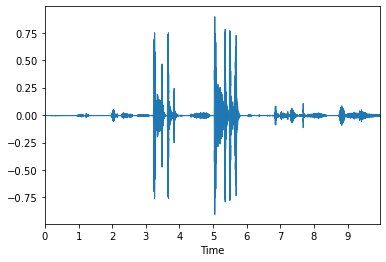

In [8]:
# plot a covid sound
s = Sound("1e8669cd-1a0a-4059-a618-6faef2fb534c.wav")
s.read()
librosa.display.waveplot(s.data, s.sr)

../final_dataset/healthy/0a84322e-b7a8-4e66-8fa0-7294eb14a2b6.wav


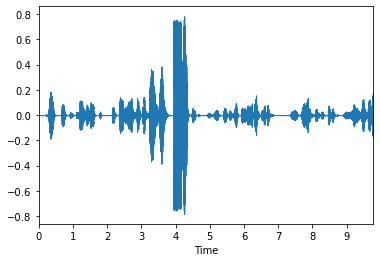

In [9]:
# plot a non covid sound
s = Sound("0a84322e-b7a8-4e66-8fa0-7294eb14a2b6.wav")
s.read()
librosa.display.waveplot(s.data, s.sr)

In [10]:
df.status = le.transform(df.status)

In [11]:
df

uuid  status
0     00039425-7f3a-42aa-ac13-834aaa2b6b92       1
1     0007c6f1-5441-40e6-9aaf-a761d8f2da3b       1
2     0009eb28-d8be-4dc1-92bb-907e53bc5c7a       1
3     001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f       1
4     001e2f19-d81c-4029-b33c-d2db56b23a4a       1
...                                    ...     ...
1425  e56ea219-e97c-45c4-8222-5ecf168445b5       0
1426  e58d45f3-7d6e-48e6-801b-eafc15f1ec85       0
1427  e5a8a140-d910-47da-b3d6-96941e084028       0
1428  e5e9bc03-88b3-432f-b8d1-ca8891b72912       0
1429  e5fd8c39-5108-4aaf-b4d5-dba3f4beaa25       0

[1430 rows x 2 columns]

### Pré-traitement des audios et séparation du dataset

In [12]:
# Récupération des mfcc de chaque audio

def getAllSounds():
    X = []
    y = []
    n_mfcc=40
    i=0
    for file in df.uuid:
        name = f"{file}.wav"
        s = Sound(name)
        y.append(s.category)
        X.append(s.mfcc())
        i+=1
    return (np.array(X), np.array(y))

In [13]:
#X, y = getAllSounds()
import pickle
X = []
y = [] 
with open("../final_dataset/X.pickle","rb") as f:
    X = pickle.load(f)
    
with open("../final_dataset/y.pickle","rb") as f:
    y = pickle.load(f)

X = np.array(X)
y = np.array(y)

In [14]:
X.shape

(1430, 40)

In [15]:
y.shape

(1430,)

In [16]:
# normalisation des données
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [17]:
# séparation du dataset
from sklearn.model_selection import train_test_split

In [18]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

In [19]:
Xtrain.shape

(1144, 40)

In [20]:
Xtest.shape

(286, 40)

In [21]:
ytrain.shape

(1144,)

### Entraînement du modèle (réseaux de neurones)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [111]:
model = Sequential([
    Dense(32, input_shape=(40,), activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.4),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", 
              optimizer="adam", metrics=["accuracy"])

In [112]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 32)                1312      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                

In [117]:
model.fit(Xtrain, ytrain,
          epochs=50, 
          batch_size=32,
          validation_data=(Xtest, ytest)
         )

Epoch 1/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6273 - accuracy: 0.6399 - val_loss: 0.6876 - val_accuracy: 0.5524
Epoch 2/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6397 - accuracy: 0.6110 - val_loss: 0.6886 - val_accuracy: 0.5350
Epoch 3/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6336 - accuracy: 0.6128 - val_loss: 0.6935 - val_accuracy: 0.5699
Epoch 4/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6297 - accuracy: 0.6154 - val_loss: 0.6768 - val_accuracy: 0.5909
Epoch 5/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6347 - accuracy: 0.6005 - val_loss: 0.6870 - val_accuracy: 0.5909
Epoch 6/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6253 - accuracy: 0.6259 - val_loss: 0.6861 - val_accuracy: 0.5629
Epoch 7/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6363 - accuracy: 0.6163 - val_loss: 0.6973 - val_accuracy: 0.5664
Epoch 8/50
36/36 [==

#### Evaluation du modèle (réseaux de neurones)

In [118]:
from sklearn.metrics import confusion_matrix, classification_report
#preds = np.where(model.predict(Xtest) >= 0.5, 1, 0)
preds = (model.predict(Xtest) > 0.5).astype("int32").ravel()
print(f"test score: {(preds == ytest).sum()/len(ytest)}")

test score: 0.5804195804195804


In [49]:
histories = pd.DataFrame(model.history.history)

<AxesSubplot:>

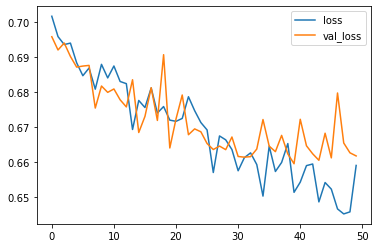

In [54]:
histories[["loss","val_loss"]].plot()

In [56]:
print(classification_report(ytest, preds))

              precision    recall  f1-score   support

           0       0.65      0.62      0.63       149
           1       0.61      0.63      0.62       137

    accuracy                           0.63       286
   macro avg       0.63      0.63      0.63       286
weighted avg       0.63      0.63      0.63       286



In [57]:
confusion_matrix(ytest, preds)

array([[93, 56],
       [51, 86]])

#### Test du modèle

In [32]:
model.predict(X[0].reshape((1,-1)))

array([[0.53262043]], dtype=float32)

In [33]:
# sauvegarde du modèle et du scaler
#import pickle
#pickle.dump(scaler, open('../../Cough On Covid - api/scaler.pickle', 'wb'))

#model.save("../../Cough On Covid - api/coughOnCovid.h5")

In [35]:
#model1 = load_model("../../Cough On Covid - api/coughOnCovid.h5")
#model1.predict(np.zeros((1,40)))

### Entraînement du modèle (Random Forest)

In [39]:
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(n_estimators=100)
model1.fit(Xtrain, ytrain)
#print("train score: "+ str(model1.score(Xtrain, ytrain)))
print("test score: "+ str(model1.score(Xtest, ytest)))

test score: 0.583916083916084


### Entraînement du modèle (SVC)

In [40]:
from sklearn.svm import SVC

model1 = SVC(kernel="linear")
model1.fit(Xtrain, ytrain)
#print("train score: "+ str(model1.score(Xtrain, ytrain)))
print("test score: "+ str(model1.score(Xtest, ytest)))

test score: 0.6153846153846154


### Entraînement du modèle (XGBoost)

In [75]:
from sklearn.ensemble import GradientBoostingClassifier
model1 = GradientBoostingClassifier(n_estimators=200)
model1.fit(Xtrain, ytrain)
#print("train score: "+ str(model1.score(Xtrain, ytrain)))
print("test score: "+ str(model1.score(Xtest, ytest)))

test score: 0.6118881118881119
